# Day 1 - 框架 & 数据

## 🎯 里程碑
本地环境 Ready，能够 **一次性拉取并清洗 10 只股票 6 年日线数据**

---

## ✅ 破冰 & 目标确认
- [x] 本地环境可用  
- [x] 一次性拉取 10 只股票最近 6 年日线  
- [x] 完成一次快速 EDA（分布 + 交互式 K 线）  
    - 日收益率计算与可视化（Pairplot）
    - 生成交互式 K 线图（Candlestick）
- [x] README 记录并推送 GitHub  


In [1]:
# 安装依赖

# %pip install yfinance
# %pip install pandas


---

## 📊 批量下载 SPY 前 10 大成分股数据

**目标**  
使用 `yfinance` 下载 SPY 前 10 大成分股近 6 年的日线数据，并保存为本地文件（推荐使用 **Parquet** 格式，便于后续增量更新与处理）。

---

## 🏦 成分股列表（截至 2025 年 7 月）

以下为 SPY 的前 10 大成分股（实际成分会随时间调整，可根据最新数据更新）：

| 股票代码 | 公司名称                     |
|----------|------------------------------|
| **AAPL** | Apple                        |
| **MSFT** | Microsoft                    |
| **AMZN** | Amazon                       |
| **NVDA** | NVIDIA                       |
| **GOOGL**| Alphabet (Class A)           |
| **META** | Meta Platforms               |
| **BRK-B**| Berkshire Hathaway (Class B) |
| **AVGO** | Broadcom                     |
| **TSLA** | Tesla                        |
| **GOOG** | Alphabet (Class C)           |

---


In [2]:
import yfinance as yf
from datetime import datetime

spy_top10 = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'BRK-B', 'AVGO', 'TSLA', 'GOOG'] # 标普500前10大成分股

start_date = (datetime.now().replace(year=datetime.now().year - 6)).strftime('%Y-%m-%d') # 6年前
end_date = datetime.now().strftime('%Y-%m-%d') # 今天

# 将每一个股票数据的返回存储为字典
data = {}
for ticker in spy_top10:
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    data[ticker] = df
print(data['AAPL']) # 打印单个公司的数据作为测试

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2019-08-19   50.650253   51.223332   50.573199   50.715264   97654400
2019-08-20   50.652653   51.372617   50.643023   50.777865  107537200
2019-08-21   51.201653   51.444849   50.951232   51.285931   86141600
2019-08-22   51.158310   51.635074   50.746557   51.334086   89014800
2019-08-23   48.793758   51.059597   48.398862   50.428723  187272000
...                ...         ...         ...         ...        ...
2025-08-11  227.179993  229.559998  224.759995  227.919998   61806100
2025-08-12  229.649994  230.800003  227.070007  228.009995   55626200
2025-08-13  233.330002  235.000000  230.429993  231.070007   69878500
2025-08-14  232.779999  235.119995  230.850006  234.059998   51916300
2025-08-15  231.589996  234.279999  229.339996  234.000000   56010500

[1507 rows x 5 colu

## 📈 EDA：日收益率计算与可视化（Pairplot）

### 代码功能
这段代码的作用是：
1. 从 `data` 字典中读取每只股票的日线收盘价；
2. 计算各股票的 **每日收益率**（`pct_change`）；
3. 将所有股票的收益率合并成一个 DataFrame（`returns`）；
4. 使用 `seaborn.pairplot` 绘制收益率的成对散点图与分布图，观察 **相关性与分布特征**。

---

### 代码解析
```python
returns_list = []
for ticker, df in data.items():
    if not df.empty and len(df) > 1:
        close = df['Close']                 # 提取收盘价
        if isinstance(close, pd.DataFrame): # 兼容情况：防止返回二维
            close = close.squeeze()
        # 计算每日收益率，并以股票代码命名
        returns_list.append(close.pct_change().rename(ticker))

# 将所有股票的收益率合并为一个宽表（列=股票，行=日期）
returns = pd.concat(returns_list, axis=1).dropna()


In [3]:
# 安装依赖

# %pip install plotly
# %pip install matplotlib
# %pip install seaborn

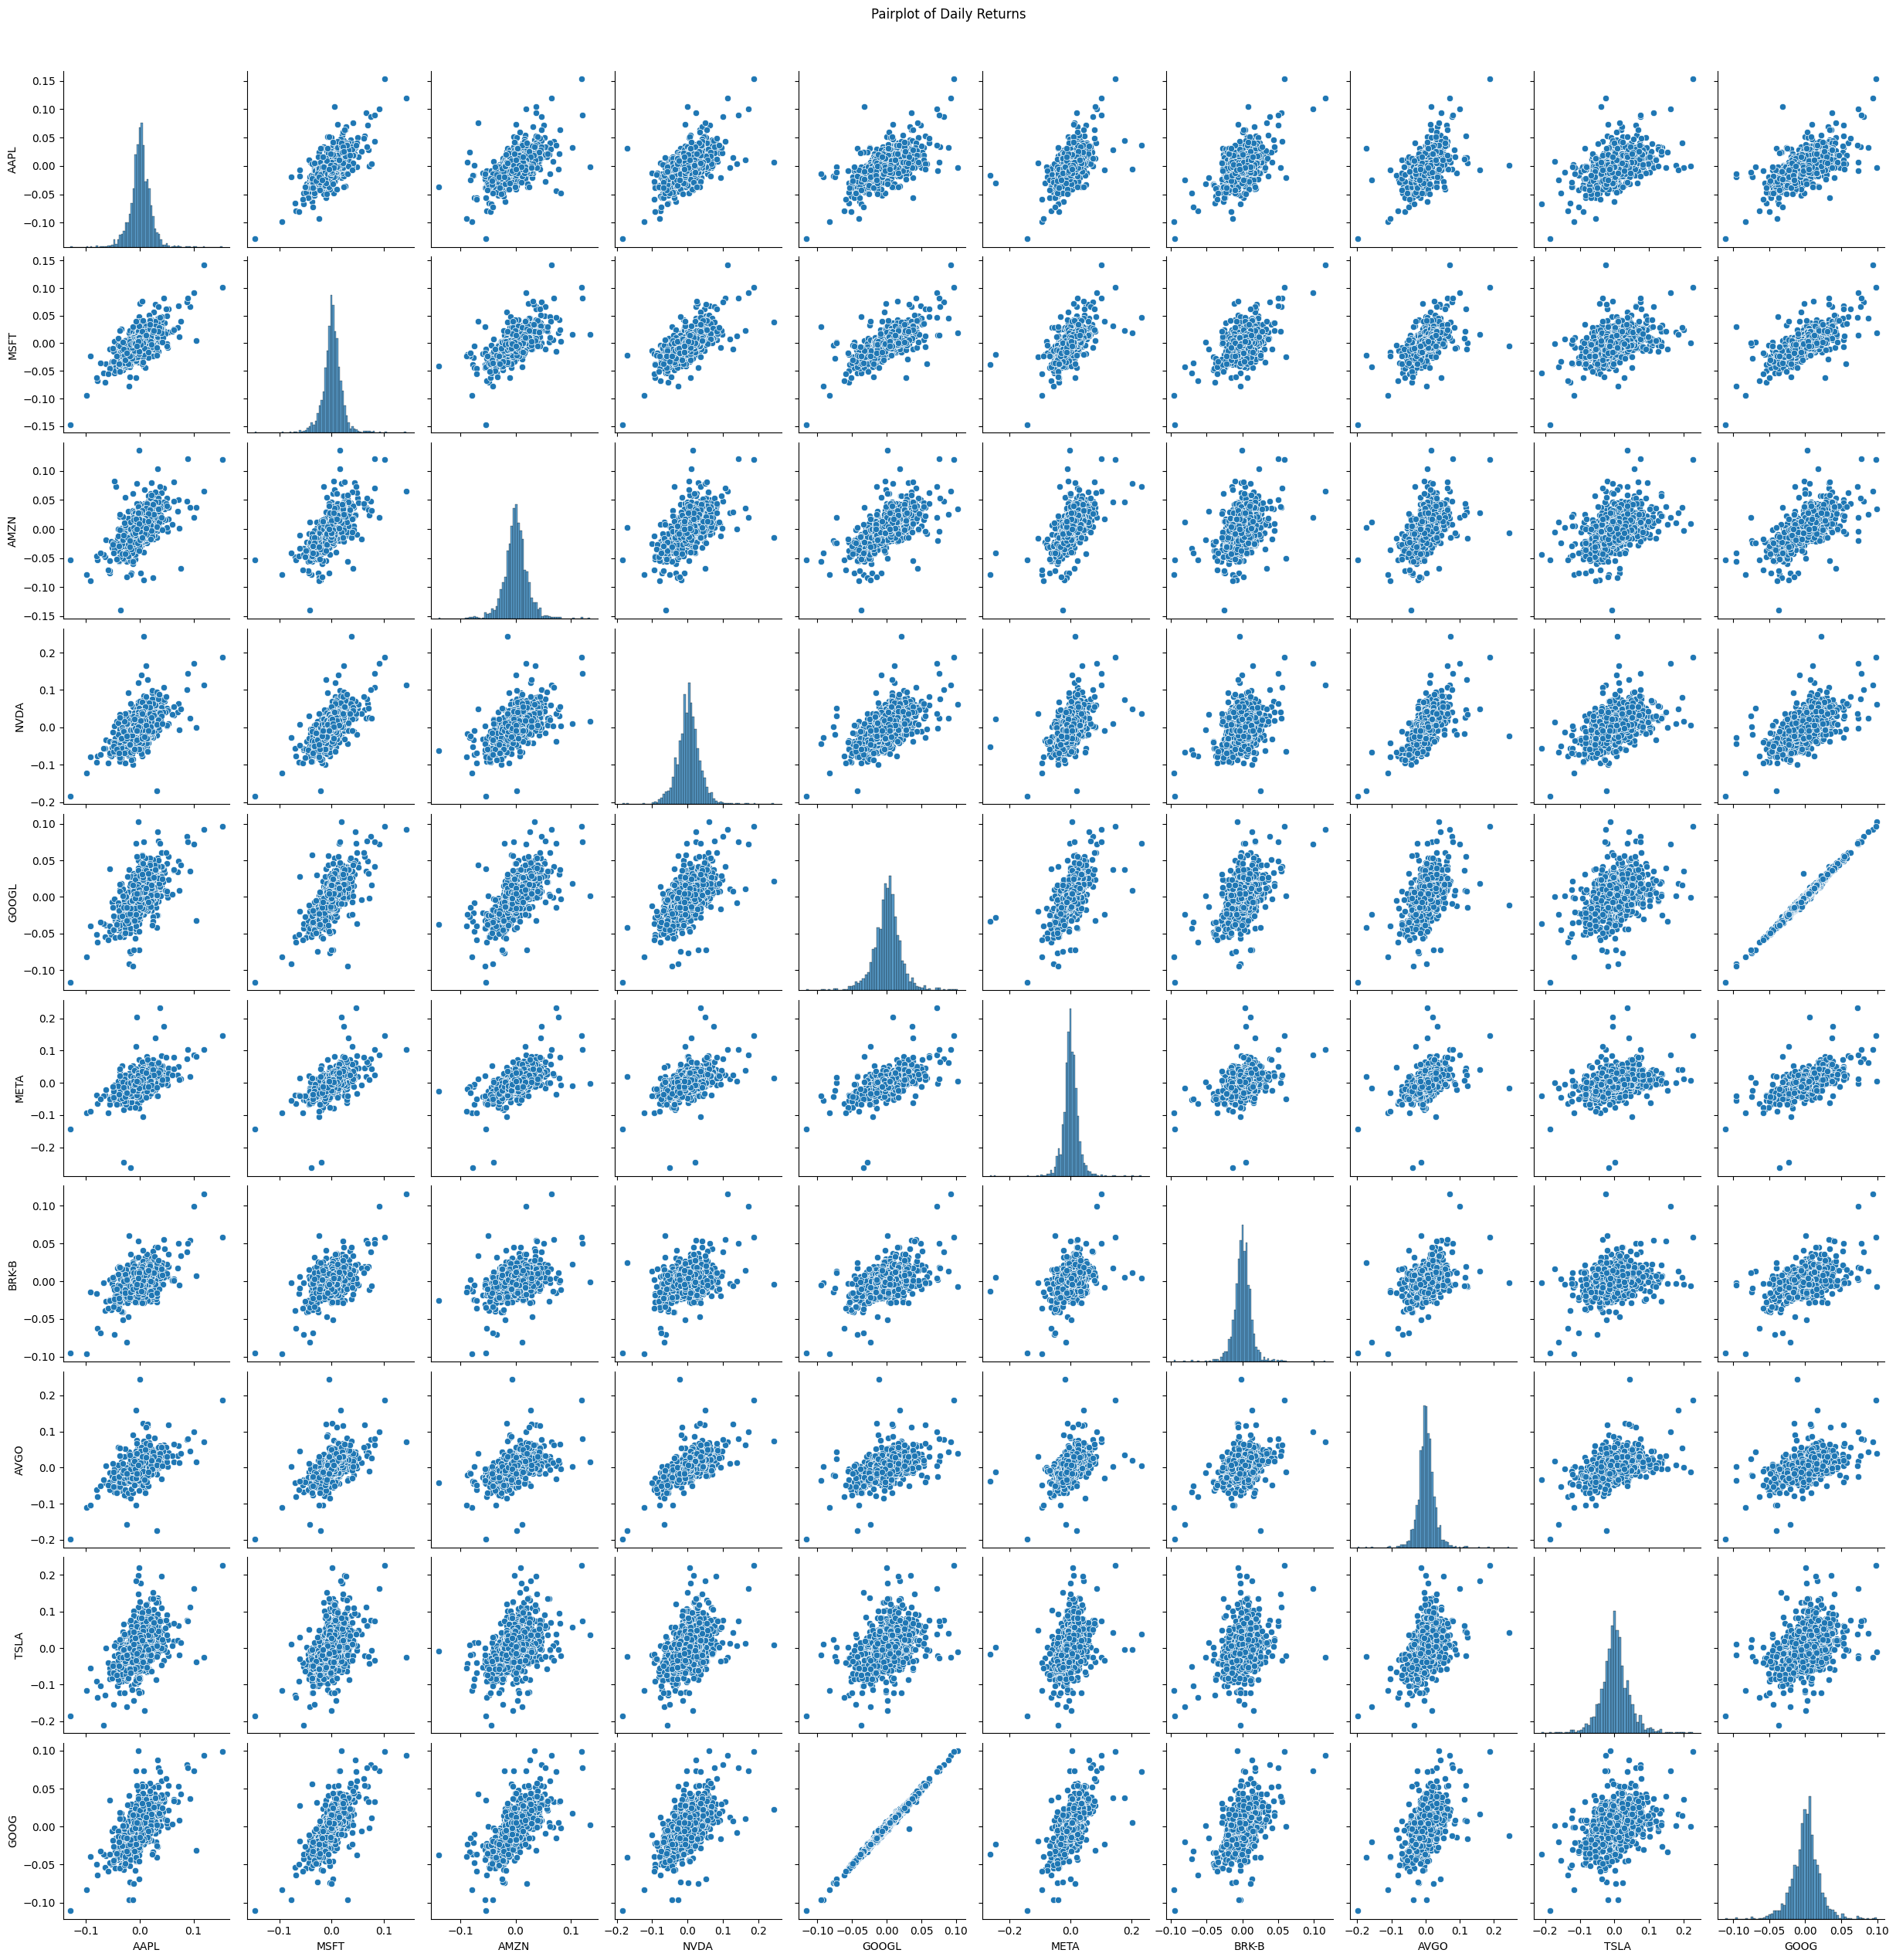

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 计算每日收益率
returns_list = []
for ticker, df in data.items():
    if not df.empty and len(df) > 1:
        close = df['Close']
        if isinstance(close, pd.DataFrame):
            close = close.squeeze()
        returns_list.append(close.pct_change().rename(ticker))
returns = pd.concat(returns_list, axis=1).dropna()

# 配对图
sns.pairplot(returns)
plt.suptitle('Pairplot of Daily Returns', y=1.02)
plt.show()


## 📊 EDA： 交互式 K 线图（Candlestick）

### 代码功能
这段代码的作用是：
1. 处理 `yfinance` 下载的数据表头，使其结构更清晰；
2. 使用 `plotly.graph_objects` 绘制 **交互式蜡烛图 (Candlestick Chart)**，展示单只股票的价格走势。

In [5]:
# 安装依赖

# %pip install plotly
# %pip install nbformat

In [6]:
import plotly.graph_objects as go  # 缩写成 go

for ticker, df in data.items():
    if df.empty:
        continue

    # 如果有多层表头，取第一层
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    fig = go.Figure(data=[
        go.Candlestick(
            x=df.index,
            open=df['Open'],
            high=df['High'],
            low=df['Low'],
            close=df['Close'],
            name=ticker
        )
    ])

    fig.update_layout(
        title=f"{ticker}",
        xaxis_title="Date",
        yaxis_title="Price",
        width=900,
        height=400
    )

    fig.show()   # ✅ 每个股票单独显示
